## 📚 01 · Introduction to Ray Train  
In this notebook you’ll learn how to run **distributed data-parallel training with PyTorch** on an Anyscale cluster using **Ray Train V2**. You’ll train a **ResNet-18 model on MNIST** across multiple GPUs, with built-in support for **checkpointing, metrics reporting, and distributed orchestration**.  

### What you’ll learn & take away
* Why and when to use **Ray Train** for distributed training instead of managing PyTorch DDP manually  
* How to wrap your PyTorch code with **`prepare_model()`** and **`prepare_data_loader()`** for multi-GPU execution  
* How to configure scale with **`ScalingConfig(num_workers=..., use_gpu=True)`** and track outputs with **`RunConfig(storage_path=...)`**  
* How to **report metrics and save checkpoints** using `ray.train.report(...)`, with best practices for rank-0 checkpointing  
* How to use **Anyscale storage**: fast local NVMe vs. persistent cluster/cloud storage  
* How to **inspect training results** (metrics DataFrame, checkpoints) and load a checkpointed model for inference with Ray  

> The entire workflow runs **fully distributed from the start**: you define your training loop once, and Ray handles orchestration, sharding, and checkpointing across the cluster.


###  🔎 When to use Ray Train  

Use Ray Train when you face one of the following challenges:

|Challenge|Detail|Solution|
|---|---|---|
|Need to speed up or scale up training| Training jobs might take a long time to complete, or require a lot of compute | Ray Train provides a distributed training framework that allows engineers to scale training jobs to multiple GPUs |
|Minimize overhead of setting up distributed training| Engineers need to manage the underlying infrastructure | Ray Train handles the underlying infrastructure via Ray's autoscaling |
|Achieve observability| Engineers need to connect to different nodes and GPUs to find the root cause of failures, fetch logs, traces, etc | Ray Train provides observability via Ray's dashboard, metrics, and traces that allow engineers to monitor the training job |
|Ensure reliable training| Training jobs can fail due to hardware failures, network issues, or other unexpected events | Ray Train provides fault tolerance via checkpointing, automatic retries, and the ability to resume training from the last checkpoint |
|Avoid significant code rewrite| Engineers might need to fully rewrite their training loop to support distributed training | Ray Train provides a suite of integrations with the PyTorch ecosystem, Tree-based methods (XGB, LGBM), and more to minimize the amount of code changes needed |

### 🖥️ How Distributed Data Parallel (DDP) Works  

The diagram above shows the **lifecycle of a single training step** in PyTorch DistributedDataParallel (DDP) when orchestrated by Ray Train:

1. **Model Replication**  
   The model is initialized on GPU rank 0 and broadcast to all other workers so that each has an identical copy.  

2. **Sharded Data Loading**  
   The dataset is automatically split into **non-overlapping shards**. Each worker processes only its shard, ensuring efficient parallelism without duplicate samples.  

3. **Forward & Backward Passes**  
   Each worker runs a forward pass and computes gradients locally during the backward pass.  

4. **Gradient Synchronization**  
   Gradients are aggregated across workers via an **AllReduce** step, ensuring that model updates stay consistent across all GPUs.  

5. **Weight Updates**  
   Once gradients are synchronized, each worker applies the update, keeping model replicas in sync.  

6. **Checkpointing & Metrics**  
   By convention, only the **rank 0 worker** saves checkpoints and logs metrics to persistent storage. This avoids duplication while preserving progress and results.  

With Ray Train, you don’t need to manage process groups or samplers manually—utilities like `prepare_model()` and `prepare_data_loader()` wrap these details so your code works out of the box in a distributed setting.

|<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_v4.png" width="70%" loading="lazy">|
|:--|
|Schematic overview of DistributedDataParallel (DDP) training: (1) the model is replicated from the <code>GPU rank 0</code> to all other workers; (2) each worker receives a shard of the dataset and processes a mini-batch; (3) during the backward pass, gradients are averaged across GPUs; (4) checkpoint and metrics from rank 0 GPU are saved to the persistent storage.|

### 01 · Imports  

Start by importing all the libraries you’ll need for this tutorial.  

- **Standard utilities**: `os`, `datetime`, `tempfile`, `csv`, `shutil`, and `gc` help with file paths, checkpointing, cleanup, and general housekeeping.  
- **Data and visualization**: `pandas`, `numpy`, `matplotlib`, and `PIL` are used for inspecting the dataset and plotting sample images.  
- **PyTorch**: core deep learning components (`torch`, `CrossEntropyLoss`, `Adam`) plus `torchvision` for loading MNIST and building a ResNet-18 model.  
- **Ray Train**: the key imports for distributed training—`ScalingConfig`, `RunConfig`, and `TorchTrainer`. These handle cluster scaling, experiment output storage, and execution of your training loop across GPUs.  

This notebook assumes Ray is already running (for example, inside an Anyscale cluster), so you don’t need to call `ray.init()` manually.

In [1]:
# 01. Imports

# --- Standard library: file IO, paths, timestamps, temp dirs, cleanup ---
import csv            # Simple CSV logging for metrics in single-GPU section
import datetime       # Timestamps for run directories / filenames
import os             # Filesystem utilities (paths, env vars)
import tempfile       # Ephemeral dirs for checkpoint staging with ray.train.report()
import shutil         # Cleanup of artifacts (later cells)
import gc             # Manual garbage collection to cleanup after inference

from pathlib import Path  # Convenient, cross-platform path handling

# --- Visualization & data wrangling ---
import matplotlib.pyplot as plt  # Plot sample digits and metrics curves
from PIL import Image            # Image utilities for inspection/debug
import numpy as np               # Numeric helpers (random sampling, arrays)
import pandas as pd              # Read metrics.csv into a DataFrame

# --- PyTorch & TorchVision (model + dataset) ---
import torch
from torch.nn import CrossEntropyLoss      # Classification loss for MNIST
from torch.optim import Adam               # Optimizer
from torchvision.models import resnet18    # Baseline CNN (we’ll adapt for 1-channel input)
from torchvision.datasets import MNIST     # Dataset
from torchvision.transforms import ToTensor, Normalize, Compose  # Preprocessing pipeline

# --- Ray Train (distributed orchestration) ---
import ray
from ray.train import ScalingConfig, RunConfig      # Configure scale and storage
from ray.train.torch import TorchTrainer            # Multi-GPU PyTorch trainer (DDP/FSDP)


### 02 · Download MNIST Dataset  

Next, download the **MNIST dataset** using `torchvision.datasets.MNIST`.  
- This will automatically fetch the dataset (if not already present) into a local `./data` directory.  
- MNIST consists of **60,000 grayscale images of handwritten digits (0–9)**, each sized **28×28 pixels**.  
- By setting `train=True`, we load the training split of the dataset.  

Once downloaded, we’ll later wrap this dataset in a `DataLoader` and apply normalization so it can be used for model training.

In [3]:
# 02. Download MNIST Dataset  

dataset = MNIST(root="/mnt/cluster_storage/data", train=True, download=True)

<div class="alert alert-info">

<b>Note about Anyscale storage options</b>

In this example, the MNIST dataset is stored under <code>/mnt/cluster_storage/</code>, which is Anyscale’s **persistent cluster storage**.  

* Unlike node-local NVMe volumes, cluster storage is **shared across nodes** in your cluster.  
* Data written here will **persist across cluster restarts**, making it a safe place for datasets, checkpoints, and results.  
* This is the recommended location for training data and artifacts you want to reuse.  

* Anyscale also provides each node with its own volume and disk and doesn’t share them with other nodes.
* Local storage is very fast - Anyscale supports the Non-Volatile Memory Express (NVMe) interface.
* Local storage is not a persisent storage, Anyscale deletes data in the local storage after instances are terminated. 

Read more about available <a href="https://docs.anyscale.com/configuration/storage" target="_blank">storage</a> options.
</div>

### 03 · Visualize Sample Digits  

Before training, let’s take a quick look at the dataset.  
- We’ll randomly sample **9 images** from the MNIST training set.  
- Each image is a **28×28 grayscale digit**, with its ground-truth label shown above the plot.  
- This simple visualization is a good sanity check to confirm that the dataset downloaded correctly and that labels align with the images.  

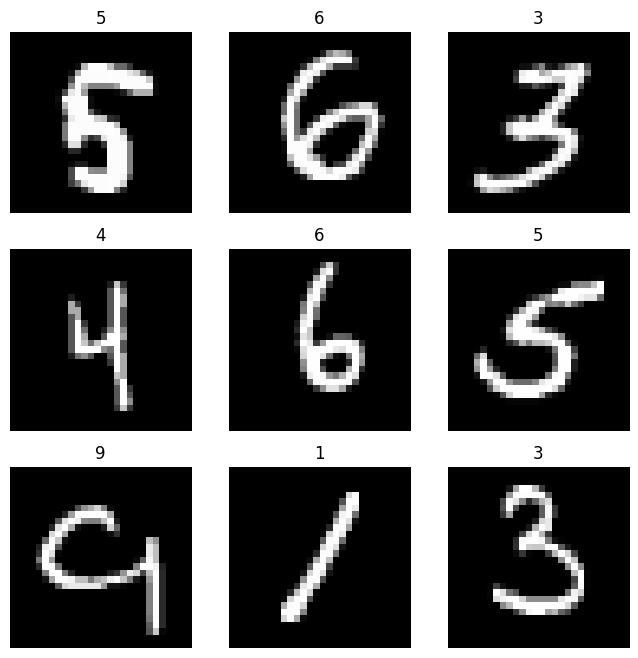

In [3]:
# 03. Visualize Sample Digits

# Create a square figure for plotting 9 samples (3x3 grid)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Loop through grid slots and plot a random digit each time
for i in range(1, cols * rows + 1):
    # Randomly select an index from the dataset
    sample_idx = np.random.randint(0, len(dataset.data))
    img, label = dataset[sample_idx]  # image (PIL) and its digit label
    
    # Add subplot to the figure
    figure.add_subplot(rows, cols, i)
    plt.title(label)         # show the digit label above each subplot
    plt.axis("off")          # remove axes for cleaner visualization
    plt.imshow(img, cmap="gray")  # display as grayscale image

### 04 · Define ResNet-18 Model for MNIST  

Now let’s define the **ResNet-18** architecture we’ll use for classification.  

- `torchvision.models.resnet18` is preconfigured for **3-channel RGB input** and **ImageNet classes**.  
- Since MNIST digits are **1-channel grayscale** images with **10 output classes**, we need two adjustments:  
  1. Override the first convolution layer (`conv1`) to accept **`in_channels=1`**.  
  2. Set the final layer to output **10 logits**, one per digit class (handled by `num_classes=10`).  

This gives us a ResNet-18 tailored for MNIST while preserving the rest of the architecture.

In [4]:
# 04. Define ResNet-18 Model for MNIST

def build_resnet18():
    # Start with a torchvision ResNet-18 backbone
    # Set num_classes=10 since MNIST has digits 0–9
    model = resnet18(num_classes=10)

    # Override the first convolution layer:
    # - Default expects 3 channels (RGB images)
    # - MNIST is grayscale → only 1 channel
    # - Keep kernel size/stride/padding consistent with original ResNet
    model.conv1 = torch.nn.Conv2d(
        in_channels=1,   # input = grayscale
        out_channels=64, # number of filters remains the same as original ResNet
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False,
    )

    # Return the customized ResNet-18
    return model

<div class="alert alert-block alert-info">

<b>Migration roadmap: from standalone PyTorch to PyTorch with Ray Train</b>  

The following are the steps to take a **regular PyTorch training loop** and run it in a **fully distributed setup with Ray Train**.  

<ol>
    <li><b>Configure scale and GPUs</b> — decide how many workers and whether each should use a GPU.</li>
    <li><b>Wrap the model with Ray Train</b> — use <code>prepare_model()</code> to move the ResNet to the right device and wrap it in DDP automatically.</li>
    <li><b>Wrap the dataset with Ray Train</b> — use <code>prepare_data_loader()</code> so each worker gets a distinct shard of MNIST, moved to the correct device.</li>
    <li><b>Add metrics & checkpointing</b> — report training loss and save checkpoints with <code>ray.train.report()</code> from rank-0.</li>
    <li><b>Configure persistent storage</b> — store outputs under <code>/mnt/cluster_storage/</code> so that results and checkpoints are available across the cluster.</li>
</ol>

</div>


Ray Train is built around [four key concepts](https://docs.ray.io/en/latest/train/overview.html):
1. **Training function**: (implemented above `train_loop_ray_train`): A Python function that contains your model training logic.
1. **Worker**: A process that runs the training function.
1. **Scaling config**: specifices number of workers and compute resources (CPUs or GPUs, TPUs).
1. **Trainer**: A Python class (Ray Actor) that ties together the training function, workers, and scaling configuration to execute a distributed training job.

|<img src="https://docs.ray.io/en/latest/_images/overview.png" width="60%" loading="lazy">|
|:--|
|High-level architecture of how Ray Train|

### 05 · Define the Ray Train Loop (DDP per-worker)

This is the **per-worker training function** that Ray executes on each process/GPU. It keeps your PyTorch code intact while Ray handles **process launch, device placement, and data sharding**.

Key points:
- **Inputs via `config`**: we pass hyperparameters like `num_epochs` and a **`global_batch_size`**.
- **Model & optimizer**: `load_model_ray_train()` returns a model already wrapped by Ray Train (DDP + correct device). We use `Adam` and `CrossEntropyLoss` for MNIST.
- **Batch sizing**: we split the global batch across workers:  
  `per_worker_batch = global_batch_size // world_size`.
- **Data sharding**: `build_data_loader_ray_train(...)` returns a DataLoader wrapped with a **DistributedSampler**; each worker sees a disjoint shard.
- **Epoch control**: `data_loader.sampler.set_epoch(epoch)` ensures proper shuffling across epochs in distributed mode.
- **Training step**: standard PyTorch loop—forward → loss → zero_grad → backward → step.
- **Metrics & checkpointing**: `print_metrics_ray_train(...)` logs loss; `save_checkpoint_and_metrics_ray_train(...)` calls `ray.train.report(...)` (rank-0 saves the checkpoint).

This function is passed to `TorchTrainer`, which runs it **concurrently on all workers**.

Let's see how this data-parallel training loop will look like with Ray Train and PyTorch.

In [6]:
# 05. Define the Ray Train per-worker training loop

def train_loop_ray_train(config: dict):  # pass in hyperparameters in config
    # config holds hyperparameters passed from TorchTrainer (e.g. num_epochs, global_batch_size)

    # Define loss function for MNIST classification
    criterion = CrossEntropyLoss()

    # Build and prepare the model for distributed training.
    # load_model_ray_train() calls ray.train.torch.prepare_model()
    # → moves model to GPU and wraps it in DistributedDataParallel (DDP).
    model = load_model_ray_train()

    # Standard optimizer (learning rate fixed for demo)
    optimizer = Adam(model.parameters(), lr=1e-5)

    # Calculate the batch size for each worker
    global_batch_size = config["global_batch_size"]
    world_size = ray.train.get_context().get_world_size()  # total # of workers in the job
    batch_size = global_batch_size // world_size  # split global batch evenly
    print(f"{world_size=}\n{batch_size=}")

    # Wrap DataLoader with prepare_data_loader()
    # → applies DistributedSampler (shards data across workers)
    # → ensures batches are automatically moved to correct device
    data_loader = build_data_loader_ray_train(batch_size=batch_size)

    # ----------------------- Training loop ----------------------- #
    for epoch in range(config["num_epochs"]):

        # Ensure each worker shuffles its shard differently every epoch
        data_loader.sampler.set_epoch(epoch)

        # Iterate over batches (sharded across workers)
        for images, labels in data_loader:
            outputs = model(images)            # forward pass
            loss = criterion(outputs, labels)  # compute loss
            optimizer.zero_grad()              # reset gradients

            loss.backward()   # backward pass (grads averaged across workers via DDP)
            optimizer.step()  # update model weights

        # After each epoch: report loss and log metrics
        metrics = print_metrics_ray_train(loss, epoch)

        # Save checkpoint (only rank-0 worker persists the model)
        save_checkpoint_and_metrics_ray_train(model, metrics)

<div class="alert alert-block alert-info">

<b>Main training loop</b>
<ul>
  <li><strong>global_batch_size</strong>: the total number of samples processed in a single training step of the entire training job.
    <ul>
      <li>It's estimated like this: <code>batch size * DDP workers * gradient accumulation steps</code>.</li>
    </ul>
  </li>
  <li>Notice that images and labels are no longer manually moved to device (<code>images.to("cuda")</code>). This is done by 
    <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader" target="_blank">
      prepare_data_loader()
    </a>.
  </li>
  <li>Config that will be passed here, is defined below. It will be passed to the Ray Train's <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.TorchTrainer.html#ray-train-torch-torchtrainer" target="_blank">TorchTrainer</a>.</li>
  <li>
    <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.v2.api.context.TrainContext.html#ray-train-v2-api-context-traincontext" target="_blank">
      TrainContext
    </a> lets users get useful information about the training i.e. node rank, world size, world rank, experiment name.
  </li>

  <li><code>load_model_ray_train</code> and <code>build_data_loader_ray_train</code> are implemented below.</li>
</ul>
</div>

### 06 · Define `train_loop_config`  

The `train_loop_config` is a simple **dictionary of hyperparameters** that Ray passes into your training loop (`train_loop_ray_train`).  

- It acts as the **bridge between the `TorchTrainer` and your per-worker training code**.  
- Anything defined here becomes available inside the `config` argument of `train_loop_ray_train`.  

In this example we define:  
- **`num_epochs`** → how many full passes through the dataset to run.  
- **`global_batch_size`** → the total batch size across all workers (Ray will split this evenly across GPUs).  

You can add other parameters here (like `learning_rate`, `embedding_dim`, etc.) and they’ll automatically be accessible in your training loop via `config["param_name"]`.  


In [5]:
# 06. Define the configuration dictionary passed into the training loop

# train_loop_config is provided to TorchTrainer and injected into
# train_loop_ray_train(config) as the "config" argument.
# → Any values defined here are accessible inside the training loop.

train_loop_config = {
    "num_epochs": 2,           # Number of full passes through the dataset
    "global_batch_size": 128   # Effective batch size across ALL workers
                               # (Ray will split this evenly per worker, e.g.
                               # with 8 workers → 16 samples/worker/step)
}


### 07 · Configure Scaling with `ScalingConfig`  

The `ScalingConfig` tells Ray Train **how many workers to launch** and **what resources each worker should use**.  

- **`num_workers=8`** → Run the training loop on 8 parallel workers. Each worker runs the same code on a different shard of the data.  
- **`use_gpu=True`** → Assign one GPU per worker. If you set this to `False`, each worker would train on CPU instead.  

This declarative config is what allows Ray to handle cluster orchestration for you — you don’t need to manually start processes or set CUDA devices.  

Later, we’ll pass this `scaling_config` into the `TorchTrainer` to launch distributed training.  

In [6]:
# 07. Configure the scaling of the training job

# ScalingConfig defines how many parallel training workers Ray should launch
# and whether each worker should be assigned a GPU or CPU.
# → Each worker runs train_loop_ray_train(config) independently,
#    with Ray handling synchronization via DDP under the hood.

scaling_config = ScalingConfig(
    num_workers=8,   # Launch 8 training workers (1 process per worker)
    use_gpu=True     # Allocate 1 GPU to each worker
)

<div class="alert alert-block alert-info">

Docs on <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.ScalingConfig.html#ray-train-scalingconfig" target="_blank">ScalingConfig</a> can be found with the link in this sentence.

See docs on configuring <a href="https://docs.ray.io/en/latest/train/user-guides/using-gpus.html" target="_blank">scale and GPUs</a> for more details.
</div>

### 08 · Wrap the Model with `prepare_model()`  

Next, we define a helper function to build and prepare the model for Ray Train.  

- Start by constructing the **ResNet-18** model adapted for MNIST using `build_resnet18()`.  
- Instead of manually calling `model.to("cuda")` and wrapping it in **DistributedDataParallel (DDP)**, we use **`ray.train.torch.prepare_model()`**.  
  * This automatically:  
    - Moves the model to the correct device (GPU or CPU).  
    - Wraps it in DDP or FSDP.  
    - Ensures gradients are synchronized across workers.  

This means the same code works whether you’re training on **1 GPU or 100 GPUs** — no manual device placement or DDP boilerplate required.  


In [7]:
# 08. Build and prepare the model for Ray Train

def load_model_ray_train() -> torch.nn.Module:
    model = build_resnet18()
    # prepare_model() → move to correct device + wrap in DDP automatically
    model = ray.train.torch.prepare_model(model)
    return model


<div class="alert alert-block alert-info">
  <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_model.html#ray-train-torch-prepare-model" target="_blank">
    prepare_model()
  </a> allows users to specify additional parameters:
  <ul>
    <li><code>parallel_strategy</code>: "ddp", "fsdp" – wrap models in <code>DistributedDataParallel</code> or <code>FullyShardedDataParallel</code></li>
    <li><code>parallel_strategy_kwargs</code>: pass additional arguments to "ddp" or "fsdp"</li>
  </ul>
  
</div>

### 09 · Build the DataLoader with `prepare_data_loader()`  

Now let’s define a helper that builds the **MNIST DataLoader** and makes it Ray Train–ready.  

- Apply standard preprocessing:  
  * `ToTensor()` → convert PIL images to PyTorch tensors  
  * `Normalize((0.5,), (0.5,))` → center and scale pixel values  

- Construct a PyTorch `DataLoader` with batching and shuffling.  

- Finally, wrap it with [`prepare_data_loader()`](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader), which automatically:  
  * Moves each batch to the correct device (GPU or CPU).  
  * Copies data from host memory to device memory as needed.  
  * Injects a PyTorch [`DistributedSampler`](https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler) when running with multiple workers, so that each worker processes a unique shard of the dataset.  

This utility lets you use the **same DataLoader code** whether you’re training on one GPU or many — Ray handles the distributed sharding and device placement for you.  

In [10]:
# 09. Build a Ray Train–ready DataLoader for MNIST

def build_data_loader_ray_train(batch_size: int) -> torch.utils.data.DataLoader:
    # Define preprocessing: convert to tensor + normalize pixel values
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    # Load the MNIST training set from persistent cluster storage
    train_data = MNIST(
        root="/mnt/cluster_storage/data",
        train=True,
        download=True,
        transform=transform,
    )

    # Standard PyTorch DataLoader (batching, shuffling, drop last incomplete batch)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

    # prepare_data_loader():
    # - Adds a DistributedSampler when using multiple workers
    # - Moves batches to the correct device automatically
    train_loader = ray.train.torch.prepare_data_loader(train_loader)
    
    return train_loader

<div class="alert alert-block alert-warning">

<b>Ray Data integration</b>

This step isn't necessary if you are integrating your Ray Train workload with Ray Data. It's especially useful if preprocessing is CPU-heavly and user wants to run preprocessing and training of separate instances.
</div>

### 10 · Report Training Metrics  

During training, it’s important to log metrics like loss values so you can monitor progress.  

This helper function prints metrics from **every worker**:  
- Collects the current **loss** and **epoch** into a dictionary.  
- Uses `ray.train.get_context().get_world_rank()` to identify which worker is reporting.  
- Prints the metrics along with the worker’s rank for debugging and visibility.   

In [8]:
# 10. Report training metrics from each worker

def print_metrics_ray_train(loss: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch}  
    world_rank = ray.train.get_context().get_world_rank() # report from all workers
    print(f"{metrics=} {world_rank=}")
    return metrics

<div class="alert alert-block alert-info">

If you want to log only from the rank 0 worker, use this code:

```python
def print_metrics_ray_train(loss: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch}
    if ray.train.get_context().get_world_rank() == 0:  # report only from the rank 0 worker
        print(f"{metrics=} {world_rank=}")
    return metrics
```

</div>

### 11 · Save Checkpoints and Report Metrics  

We will report intermediate metrics and checkpoints using the [`ray.train.report`](https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray-train-report) utility function.  

This helper function:  
- Creates a temporary directory to stage the checkpoint.  
- Saves the model weights with `torch.save()`.  
  * Since the model is wrapped in **DistributedDataParallel (DDP)**, we call `model.module.state_dict()` to unwrap it.  
- Calls `ray.train.report()` to:  
  * Log the current metrics (e.g., loss, epoch).  
  * Attach a `Checkpoint` object created from the staged directory.  

This way, each epoch produces both **metrics for monitoring** and a **checkpoint for recovery or inference**.  

In [9]:
# 11. Save checkpoint and report metrics with Ray Train

def save_checkpoint_and_metrics_ray_train(model: torch.nn.Module, metrics: dict[str, float]) -> None:
    # Create a temporary directory to stage checkpoint files
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        # Save the model weights.
        # Note: under DDP the model is wrapped in DistributedDataParallel,
        # so we unwrap it with `.module` before calling state_dict().        
        torch.save(
            model.module.state_dict(),  # note the `.module` to unwrap the DistributedDataParallel
            os.path.join(temp_checkpoint_dir, "model.pt"),
        )
        
        # Report metrics and attach a checkpoint to Ray Train.
        # → metrics are logged centrally
        # → checkpoint allows resuming training or running inference later
        ray.train.report(
            metrics,
            checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
        )

<div class="alert alert-block alert-info">
  <p><strong>Quick notes:</strong></p>
  <ul>
    <li>
      Use 
      <a href="https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray.train.report" target="_blank">
        ray.train.report
      </a> to save the metrics and checkpoint.
    </li>
    <li>Only metrics from the rank 0 worker are reported.</li>
  </ul>
</div>

### Note on the Checkpoint Lifecycle  

The diagram above shows how a checkpoint moves from **local storage** (temporary directory on a worker) to **persistent cluster or cloud storage**.  

Key points to remember:  
- Since the model is identical across all workers, it’s enough to **write the checkpoint only on the rank-0 worker**.  
  * However, you still need to call [`ray.train.report`](https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray-train-report) on **all workers** to keep the training loop synchronized.  
- Ray Train expects every worker to have access to the **same persistent storage location** for writing files.  
- For production jobs, **cloud storage** (e.g., S3, GCS, Azure Blob) is the recommended target for checkpoints.  


<img src="https://docs.ray.io/en/latest/_images/checkpoint_lifecycle.png" width=800>


### 12 · Save Checkpoints on Rank-0 Only  

To avoid redundant writes, we update the checkpointing function so that **only the rank-0 worker** saves the model weights.  

- **Temporary directory** → Each worker still creates a temp directory, but only rank-0 writes the model file.  
- **Rank check** → `ray.train.get_context().get_world_rank()` ensures that only worker 0 performs the checkpointing.  
- **All workers report** → Every worker still calls [`ray.train.report`](https://docs.ray.io/en/latest/train/api/doc/ray.train.report.html#ray-train-report), but only rank-0 attaches the actual checkpoint. This keeps the training loop synchronized.  

This pattern is the recommended best practice:  
- Avoids unnecessary duplicate checkpoints from multiple workers.  
- Still guarantees that metrics are reported from every worker.  
- Ensures checkpoints are cleanly written once per epoch to persistent storage.  

In [10]:
# 12. Save checkpoint only from the rank-0 worker

def save_checkpoint_and_metrics_ray_train(model: torch.nn.Module, metrics: dict[str, float]) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        checkpoint = None

        # Only the rank-0 worker writes the checkpoint file
        if ray.train.get_context().get_world_rank() == 0:
            torch.save(
                model.module.state_dict(),  # unwrap DDP before saving
                os.path.join(temp_checkpoint_dir, "model.pt"),
            )
            checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)

        # All workers still call ray.train.report()
        # → keeps training loop synchronized
        # → metrics are logged from each worker
        # → only rank-0 attaches a checkpoint
        ray.train.report(
            metrics,
            checkpoint=checkpoint,
        )


Check our guide on [saving and loading checkpoints](https://docs.ray.io/en/latest/train/user-guides/checkpoints.html) for more details and best practices.

### 13 · Configure Persistent Storage with `RunConfig`  

To tell Ray Train **where to store results, checkpoints, and logs**, we use a [`RunConfig`](https://docs.ray.io/en/latest/train/api/doc/ray.train.RunConfig.html).  

- **`storage_path`** → Base directory for all outputs of this training run.  
  * In this example we use `/mnt/cluster_storage/training/`, which is **persistent shared storage** across all nodes.  
  * This ensures checkpoints and metrics remain available even after the cluster shuts down.  
- **`name`** → A human-readable name for the run (e.g., `"distributed-mnist-resnet18"`). This is used to namespace output files.  

Together, the `RunConfig` defines how Ray organizes and persists all artifacts from your training job.  

In [17]:
# 13. Configure persistent storage and run name

storage_path = "/mnt/cluster_storage/training/"
run_config = RunConfig(
    storage_path=storage_path,         # where to store checkpoints/logs
    name="distributed-mnist-resnet18"  # identifier for this run
)

(autoscaler +36m30s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


### Distributed Data-Parallel Training with Ray Train  

This diagram shows the same DDP workflow as before, but now with **Ray Train utilities** highlighted:  

1. **`ray.train.torch.prepare_data_loader()`**  
   - Automatically wraps your PyTorch DataLoader with a `DistributedSampler`.  
   - Ensures each worker processes a unique shard of the dataset.  
   - Moves batches to the correct device (GPU or CPU).  

2. **`ray.train.torch.prepare_model()`**  
   - Moves your model to the right device.  
   - Wraps it in `DistributedDataParallel (DDP)` so gradients are synchronized across workers.  
   - Removes the need for manual `.to("cuda")` calls or DDP boilerplate.  

3. **`ray.train.report()`**  
   - Centralized way to report metrics and attach checkpoints.  
   - Keeps the training loop synchronized across all workers, even if only rank-0 saves the actual checkpoint.  

By combining these helpers, Ray Train takes care of the **data sharding, model replication, gradient synchronization, and checkpoint lifecycle** — letting you keep your training loop clean and close to standard PyTorch.  


|<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_annotated_v5.png" width="70%" loading="lazy">|
|:--|
||

### 14 · Create the `TorchTrainer`  

Now we bring everything together with a [`TorchTrainer`](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.TorchTrainer.html).  

The `TorchTrainer` is the high-level Ray Train class that:  
- Launches the per-worker training loop (`train_loop_ray_train`) across the cluster.  
- Applies the scaling setup from `scaling_config` (number of workers, GPUs/CPUs).  
- Uses `run_config` to decide where results and checkpoints are stored.  
- Passes `train_loop_config` (hyperparameters like `num_epochs` and `global_batch_size`) into the training loop.  

This object encapsulates the **distributed orchestration**, so you can start training with a simple call to `trainer.fit()`.  

In [15]:
# 14. Set up the TorchTrainer

trainer = TorchTrainer(
    train_loop_ray_train,          # training loop to run on each worker
    scaling_config=scaling_config, # number of workers and resource config
    run_config=run_config,         # storage path + run name for artifacts
    train_loop_config=train_loop_config,  # hyperparameters passed to the loop
)

2026-01-25 20:15:57,537	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 100.65.165.80:6379...
2026-01-25 20:15:57,547	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-8aj4w8jgcnwgc4ecvv8dqi2pju.i.anyscaleuserdata.com 
2026-01-25 20:15:57,550	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_5d903ce6a08c867919a1bbcece9ebb834a590b56.zip' (0.13MiB) to Ray cluster...
2026-01-25 20:15:57,551	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_5d903ce6a08c867919a1bbcece9ebb834a590b56.zip'.


### 15 · Launch Training with `trainer.fit()`  

Calling `trainer.fit()` starts the distributed training job and blocks until it completes.  

When the job launches, you’ll see logs that confirm:  
- **Process group setup** → Ray initializes a distributed worker group and assigns ranks (e.g., `world_rank=0` and `world_rank=1`).  
- **Worker placement** → Each worker is launched on a specific node and device. The logs show IP addresses, process IDs, and rank assignments.  
- **Model preparation** → Each worker moves the model to its GPU (`cuda:0`) and wraps it in **DistributedDataParallel (DDP)**.  

These logs are a quick sanity check that Ray Train is correctly orchestrating multi-GPU training across your cluster.  

|<img src="https://assets-training.s3.us-west-2.amazonaws.com/ray-intro/ray-train-intro-logs.png" width="80%" loading="lazy">|
|:--|
||

In [16]:
# 15. Launch distributed training

# trainer.fit() starts the training job:
# - Spawns workers according to scaling_config
# - Runs train_loop_ray_train() on each worker
# - Collects metrics and checkpoints into result
result = trainer.fit()

2026-01-25 20:17:45,939	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2026-01-25 20:17:46 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/8 CPUs, 0/0 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/provider:aws, 0.0/1.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-25_19-19-34_277767_2176/artifacts/2026-01-25_20-17-45/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2026-01-25 20:17:51 (running for 00:00:05.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/8 CPUs, 0/0 GPUs (0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/provider:aws, 0.0/1.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-25_19-19-34_277767_2176/artifacts/2026-01-25_20-17-45/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 PENDING)


(autoscaler +38m1s) Tip: use `ray status` to view detailed cluster status. To disable th

(RayTrainWorker pid=3871, ip=100.121.141.128) Setting up process group for: env:// [rank=0, world_size=8]


== Status ==
Current time: 2026-01-25 20:20:27 (running for 00:02:40.81)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/provider:aws, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-25_19-19-34_277767_2176/artifacts/2026-01-25_20-17-45/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(TorchTrainer pid=3779, ip=100.121.141.128) Started distributed worker processes: 
(TorchTrainer pid=3779, ip=100.121.141.128) - (node_id=41a4bf1af0fdfde8c7872453d96b4ea37257accd0483069067475611, ip=100.121.141.128, pid=3871) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=3779, ip=100.121.141.128) - (node_id=41a4bf1af0fdfde8c7872453d96b4ea37257accd0483069067475611, ip=100.121.141.128, pid=3873) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=3779, ip=100.121.141.128) - (node_id=41a4bf1af0fdfde8c7872453d96b4ea37257accd0483069067475611, ip=100.121.141.128, pid=3870) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=3779, ip=100.121.141.128) - (node_id=41a4bf1af0fdfde8c7872453d96b4ea37257accd0483069067475611, ip=100.121.141.128, pid=3872) world_rank=3, local_rank=3, node_rank=0
(TorchTrainer pid=3779, ip=100.121.141.128) - (node_id=b3af9be14f793272126acd44a23dd07b1166edb88d13cc6475e57f0f, ip=100.106.75.71, pid=3947) world_rank=4, local_rank=0, node_rank=1
(Tor

(RayTrainWorker pid=3946, ip=100.106.75.71) world_size=8
(RayTrainWorker pid=3946, ip=100.106.75.71) batch_size=16
(RayTrainWorker pid=3947, ip=100.106.75.71) world_size=8
(RayTrainWorker pid=3947, ip=100.106.75.71) batch_size=16
(RayTrainWorker pid=3945, ip=100.106.75.71) world_size=8
(RayTrainWorker pid=3945, ip=100.106.75.71) batch_size=16
(RayTrainWorker pid=3948, ip=100.106.75.71) world_size=8
(RayTrainWorker pid=3948, ip=100.106.75.71) batch_size=16
(RayTrainWorker pid=3873, ip=100.121.141.128) world_size=8
(RayTrainWorker pid=3873, ip=100.121.141.128) batch_size=16
(RayTrainWorker pid=3872, ip=100.121.141.128) world_size=8
(RayTrainWorker pid=3872, ip=100.121.141.128) batch_size=16
(RayTrainWorker pid=3870, ip=100.121.141.128) world_size=8
(RayTrainWorker pid=3870, ip=100.121.141.128) batch_size=16
(RayTrainWorker pid=3871, ip=100.121.141.128) world_size=8
(RayTrainWorker pid=3871, ip=100.121.141.128) batch_size=16
== Status ==
Current time: 2026-01-25 20:20:32 (running for 00:0

(RayTrainWorker pid=3871, ip=100.121.141.128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/distributed-mnist-resnet18/TorchTrainer_e9613_00000_0_2026-01-25_20-17-46/checkpoint_000000)
(RayTrainWorker pid=3947, ip=100.106.75.71) Moving model to device: cuda:0
(RayTrainWorker pid=3947, ip=100.106.75.71) Wrapping provided model in DistributedDataParallel.


== Status ==
Current time: 2026-01-25 20:20:47 (running for 00:03:00.92)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-25_19-19-34_277767_2176/artifacts/2026-01-25_20-17-45/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2026-01-25 20:20:52 (running for 00:03:05.94)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tm

(RayTrainWorker pid=3871, ip=100.121.141.128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/distributed-mnist-resnet18/TorchTrainer_e9613_00000_0_2026-01-25_20-17-46/checkpoint_000001)
2026-01-25 20:20:59,972	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/training/distributed-mnist-resnet18' in 0.1565s.
2026-01-25 20:20:59,975	INFO tune.py:1041 -- Total run time: 194.04 seconds (193.54 seconds for the tuning loop).


== Status ==
Current time: 2026-01-25 20:20:59 (running for 00:03:13.70)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-25_19-19-34_277767_2176/artifacts/2026-01-25_20-17-45/distributed-mnist-resnet18/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




(autoscaler +45m11s) [autoscaler] Downscaling node i-0fb87900ce4a99d16 (node IP: 100.106.75.71) due to node idle termination.
(autoscaler +45m11s) [autoscaler] Downscaling node i-0ad7a469723d7bf50 (node IP: 100.121.141.128) due to node idle termination.
(autoscaler +45m11s) [autoscaler] Cluster resized to {8 CPU, 0 GPU}.


### 16 · Inspect the Training Results  

When `trainer.fit()` finishes, it returns a [`Result`](https://docs.ray.io/en/latest/train/api/doc/ray.train.Result.html) object.  

This object contains:  
- **Final metrics** → the most recent values reported from the training loop (e.g., loss at the last epoch).  
- **Checkpoint** → a reference to the latest saved checkpoint, including its path in cluster storage.  
- **Metrics dataframe** → a history of all reported metrics across epochs (accessible with `result.metrics_dataframe`).  
- **Best checkpoints** → Ray automatically tracks checkpoints associated with their reported metrics.  

In the output above, you can see:  
- The final reported loss at epoch 1.  
- The location where checkpoints are stored (`/mnt/cluster_storage/training/distributed-mnist-resnet18/...`).  
- A list of best checkpoints with their corresponding metrics.  

This makes it easy to both **analyze training performance** and **restore the trained model** later for inference.  

In [17]:
# 16. Show the training results  

result  # contains metrics, checkpoints, and run history

Result(
  metrics={'loss': 0.23726031184196472, 'epoch': 1},
  path='/mnt/cluster_storage/training/distributed-mnist-resnet18/TorchTrainer_e9613_00000_0_2026-01-25_20-17-46',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/distributed-mnist-resnet18/TorchTrainer_e9613_00000_0_2026-01-25_20-17-46/checkpoint_000001)
)

### 17 · View Metrics as a DataFrame  

The `Result` object also includes a `metrics_dataframe`, which stores the full history of metrics reported during training.  

- Each row corresponds to one reporting step (here, each epoch).  
- The columns show the metrics you logged in the training loop (e.g., `loss`, `epoch`).  
- This makes it easy to plot learning curves or further analyze training progress.  

In the example below, you can see the training loss steadily decreasing across two epochs.  

In [18]:
# 17. Display the full metrics history as a pandas DataFrame

result.metrics_dataframe

,loss,epoch,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/num_epochs,config/train_loop_config/global_batch_size
0,0.390775,0,1769372444,checkpoint_000000,True,False,1,e9613_00000,2026-01-25_20-20-44,22.606221,22.606221,3779,ip-10-0-96-14,100.121.141.128,22.606221,1,2,128
1,0.237260,1,1769372457,checkpoint_000001,True,False,2,e9613_00000,2026-01-25_20-20-58,13.689027,36.295248,3779,ip-10-0-96-14,100.121.141.128,36.295248,2,2,128


<div class="alert alert-block alert-info">
  <p>
    To learn more about the training results, see this 
    <a href="https://docs.ray.io/en/latest/train/user-guides/results.html" target="_blank">
      docs
    </a> on inspecting the training results.
  </p>
</div>

### 18 · Load a Checkpoint for Inference  

After training, we often want to reload the model and use it for predictions.  
Here we define a **Ray actor** (`ModelWorker`) that loads the checkpointed ResNet-18 onto a GPU and serves inference requests.  

- **Initialization (`__init__`)**:  
  * Reads the checkpoint directory using `checkpoint.as_directory()`.  
  * Loads the model weights into a fresh ResNet-18.  
  * Moves the model to GPU and sets it to evaluation mode.  

- **Prediction (`predict`)**:  
  * Accepts either a single image (`[C,H,W]`) or a batch (`[B,C,H,W]`).  
  * Ensures the tensor is correctly shaped and moved to GPU.  
  * Runs inference in `torch.inference_mode()` for efficiency.  
  * Returns the predicted class indices as a Python list.  

Finally, we launch the actor with `ModelWorker.remote(result.checkpoint)`.  
This spawns a dedicated process with **1 GPU** attached that can serve predictions using the trained model.  

In [19]:
# 18. Define a Ray actor to load the trained model and run inference

@ray.remote(num_gpus=1)  # allocate 1 GPU to this actor
class ModelWorker:
    def __init__(self, checkpoint):
        # Load model weights from the Ray checkpoint (on CPU first)
        with checkpoint.as_directory() as ckpt_dir:
            model_path = os.path.join(ckpt_dir, "model.pt")
            state_dict = torch.load(
                model_path,
                map_location=torch.device("cpu"),
                weights_only=True,
            )
        # Rebuild the model, load weights, move to GPU, and set to eval mode
        self.model = build_resnet18()
        self.model.load_state_dict(state_dict)
        self.model.to("cuda")
        self.model.eval()

    @torch.inference_mode()  # disable autograd for faster inference
    def predict(self, batch):
        """
        batch: torch.Tensor or numpy array with shape [B,C,H,W] or [C,H,W]
        returns: list[int] predicted class indices
        """
        x = torch.as_tensor(batch)
        if x.ndim == 3:          # single image → add batch dimension
            x = x.unsqueeze(0)   # shape becomes [1,C,H,W]
        x = x.to("cuda", non_blocking=True)

        logits = self.model(x)
        preds = torch.argmax(logits, dim=1)
        return preds.detach().cpu().tolist()

# Create a fresh actor instance (avoid naming conflicts)
worker = ModelWorker.remote(result.checkpoint)

(autoscaler +47m46s) [autoscaler] [1xT4:8CPU-32GB] Attempting to add 1 node to the cluster (increasing from 0 to 1).
(autoscaler +47m46s) [autoscaler] [1xT4:8CPU-32GB|g4dn.2xlarge] [us-east-2b] [on-demand] Launched 1 instance.
(autoscaler +48m26s) [autoscaler] Cluster upscaled to {16 CPU, 1 GPU}.


### 19 · Run Inference and Visualize Predictions  

With the `ModelWorker` actor running on GPU, we can now generate predictions on random samples from the MNIST dataset and plot them.  

Steps in this cell:  
1. **Normalization on CPU**  
   - Convert each image to a tensor with `ToTensor()`.  
   - Apply channel-specific normalization (`0.5` mean / std).  
   - Keep this preprocessing on CPU for efficiency.  

2. **Prediction on GPU via Actor**  
   - Each normalized image is expanded to shape `[1, C, H, W]`.  
   - The tensor is sent to the remote `ModelWorker` for inference.  
   - `ray.get(worker.predict.remote(x))` retrieves the predicted class index.  

3. **Plot Results**  
   - Display a 3×3 grid of random MNIST samples.  
   - Each subplot shows the **true label** and the **predicted label** from the trained ResNet-18.  

This demonstrates a simple but practical workflow: **CPU-based preprocessing + GPU-based inference in a Ray actor**.  

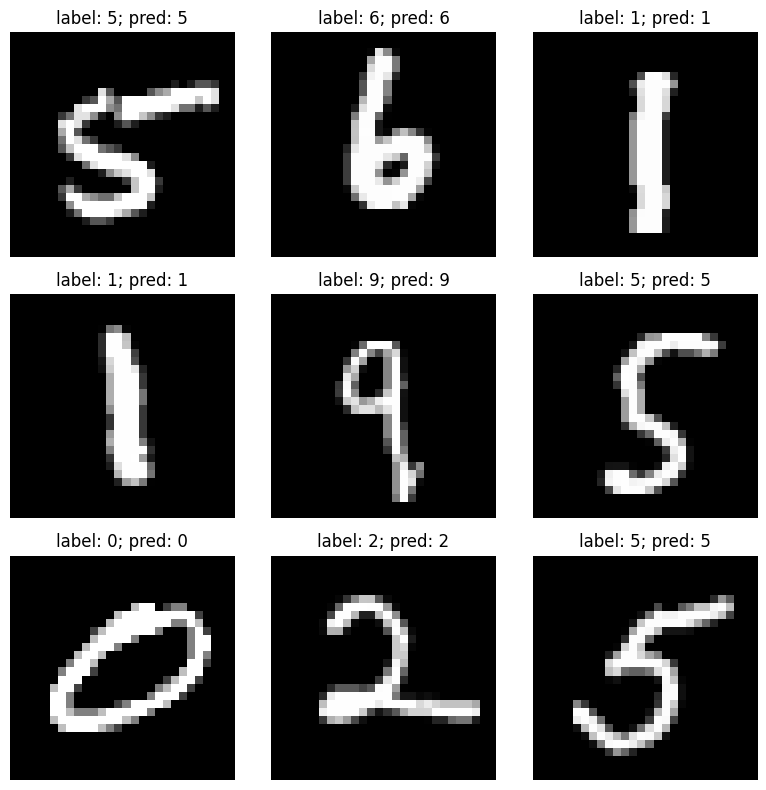

In [20]:
# 19. CPU preprocessing + GPU inference via Ray actor

to_tensor = ToTensor()

def normalize_cpu(img):
    # Convert image (PIL) to tensor on CPU → shape [C,H,W]
    t = to_tensor(img)                # [C,H,W] on CPU
    C = t.shape[0]
    # Apply channel-wise normalization (grayscale vs RGB)
    if C == 3:
        norm = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    else:
        norm = Normalize((0.5,), (0.5,))
    return norm(t)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Plot a 3x3 grid of random MNIST samples with predictions
for i in range(1, cols * rows + 1):
    idx = np.random.randint(0, len(dataset))
    img, label = dataset[idx]

    # Preprocess on CPU, add batch dim → [1,C,H,W]
    x = normalize_cpu(img).unsqueeze(0)    

    # Run inference on GPU via Ray actor, fetch result   
    pred = ray.get(worker.predict.remote(x))[0]  # int
    
    # Plot image with true label and predicted label
    figure.add_subplot(rows, cols, i)
    plt.title(f"label: {label}; pred: {int(pred)}")
    plt.axis("off")
    arr = np.array(img)
    plt.imshow(arr, cmap="gray" if arr.ndim == 2 else None)

plt.tight_layout()
plt.show()

### 20 · Clean Up the Ray Actor  

Once you’re done running inference, it’s a good practice to free up resources:  

- **`ray.kill(worker, no_restart=True)`** → stops the `ModelWorker` actor and releases its GPU.  
- **`del worker` + `gc.collect()`** → drop local references so Python’s garbage collector can clean up.  

This ensures the GPU is no longer pinned by the actor and can be reused for other jobs.  

In [21]:
# 20.

# stop the actor process and free its GPU
ray.kill(worker, no_restart=True)     

# drop local references so nothing pins it
del worker

# Forcing garbage collection is optional:
# - Cluster resources are already freed by ray.kill()
# - Python will clean up the local handle eventually
# - gc.collect() is usually unnecessary unless debugging memory issues
gc.collect()

19079

### End of Module 01 · Introduction to Ray Train


## 🔄 02 · Integrating Ray Train with Ray Data  
In this module you’ll extend distributed training with **Ray Train** by adding **Ray Data** to the pipeline. Instead of relying on a local PyTorch DataLoader, you’ll stream batches directly from a distributed **Ray Dataset**, enabling scalable preprocessing and just-in-time data loading across the cluster.  

### What you’ll learn & take away  
* When to integrate **Ray Data** with Ray Train — e.g., for CPU-heavy preprocessing, online augmentations, or multi-format data ingestion  
* How to replace `DataLoader` with **`iter_torch_batches()`** to stream batches into your training loop  
* How to shard, shuffle, and preprocess data in parallel across the cluster before feeding it into GPUs  
* How to define a **training loop** that consumes Ray Dataset shards instead of DataLoader tuples  
* How to prepare datasets (For example, Parquet format) so they can be efficiently read and transformed with Ray Data  
* How to pass Ray Datasets into the `TorchTrainer` with the `datasets` parameter  

> With Ray Data, you can scale preprocessing and training independently — CPUs handle input pipelines, GPUs focus on training — ensuring **higher utilization and throughput** in your distributed workloads.  

Note that the code blocks for this module will depend on the previous module, **Introduction to Ray Train**.

### 🔎 Integrating Ray Train with Ray Data  

Use both Ray Train and Ray Data when you face one of the following challenges:  
| Challenge | Detail | Solution |
| --- | --- | --- |
| Need to perform online or just-in-time data processing | The training pipeline requires processing data on the fly, such as data augmentation, normalization, or other transformations that may differ for each training epoch. | Ray Train's integration with Ray Data makes it easy to implement just-in-time data processing. |
| Need to improve hardware utilization | Training and data processing need to be scaled independently to keep GPUs fully utilized, especially when preprocessing is CPU-intensive. | Ray Data can distribute data processing across multiple CPU nodes, while Ray Train runs the training loop on GPUs. |
| Need a consistent interface for loading data | The training process may need to load data from various sources, such as Parquet, CSV, or lakehouses. | Ray Data provides a consistent interface for loading, shuffling, sharding, and batching data for training loops. |

### 01 · Define Training Loop with Ray Data  

Here we reimplement the training loop, but this time using **Ray Data** instead of a PyTorch `DataLoader`.  

Key differences from the previous version:  
- **Data loader** → Built with `build_data_loader_ray_train_ray_data()`, which streams batches from a Ray Dataset shard (details in the following block).  
- **Batching** → Still split by `global_batch_size // world_size`, but batches are now **dictionaries** with keys `"image"` and `"label"`.  
- **No device management needed** → Ray Data automatically moves batches to the correct device, so we no longer call `sampler.set_epoch()` or `to("cuda")`.  

The rest of the loop (forward pass, loss computation, backward pass, optimizer step, metric logging, and checkpointing) stays the same.  

This pattern shows how seamlessly **Ray Data integrates with Ray Train**, replacing `DataLoader` while keeping the training logic identical.  

In [2]:
# 01. Training loop using Ray Data

def train_loop_ray_train_ray_data(config: dict):
    # Same as before: define loss, model, optimizer
    criterion = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Different: build data loader from Ray Data instead of PyTorch DataLoader
    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train_ray_data(batch_size=batch_size) 
    
    # Same: loop over epochs
    for epoch in range(config["num_epochs"]):
        # Different: no sampler.set_epoch(), Ray Data handles shuffling internally

        # Different: batches are dicts {"image": ..., "label": ...} not tuples
        for batch in data_loader: 
            outputs = model(batch["image"])
            loss = criterion(outputs, batch["label"])
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

        # Same: report metrics and save checkpoint each epoch
        metrics = print_metrics_ray_train(loss, epoch)
        save_checkpoint_and_metrics_ray_train(model, metrics)

### 02 · Build DataLoader from Ray Data  

Instead of using PyTorch’s `DataLoader`, we now build a loader from a **Ray Dataset shard**.  

- `ray.train.get_dataset_shard("train")` → retrieves the shard of the training dataset assigned to the current worker.  
- `.iter_torch_batches()` → streams the shard as PyTorch-compatible batches.  
  * Each batch is a **dictionary** (e.g., `{"image": tensor, "label": tensor}`).  
  * Supports options like `batch_size` and `prefetch_batches` for performance tuning.  

This integration ensures that data is **sharded, shuffled, and moved to the right device automatically**, while still looking and feeling like a familiar PyTorch data loader.  

**Note:** Use [`iter_torch_batches`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.iter_torch_batches.html) to build a PyTorch-compatible data loader from a Ray Dataset. 

In [11]:
# 02. Build a Ray Data–backed data loader

def build_data_loader_ray_train_ray_data(batch_size: int, prefetch_batches: int = 2):

    # Different: instead of creating a PyTorch DataLoader,
    # fetch the training dataset shard for this worker
    dataset_iterator = ray.train.get_dataset_shard("train")

    # Convert the shard into a PyTorch-style iterator
    # - Returns dict batches: {"image": ..., "label": ...}
    # - prefetch_batches controls pipeline buffering
    data_loader = dataset_iterator.iter_torch_batches(
        batch_size=batch_size, prefetch_batches=prefetch_batches
    )
    
    return data_loader

### 03 · Prepare Dataset for Ray Data  

Ray Data works best with data in **tabular formats** such as Parquet.  
In this step we:  

- Convert the MNIST dataset into a **pandas DataFrame** with two columns:  
  * `"image"` → raw image arrays  
  * `"label"` → digit class (0–9)  
- Write the DataFrame to disk in **Parquet format** under `/mnt/cluster_storage/`.  

Parquet is efficient for both reading and distributed processing, making it a good fit for Ray Data pipelines.  

In [12]:
# 03. Convert MNIST dataset into Parquet for Ray Data

# Build a DataFrame with image arrays and labels
df = pd.DataFrame({
    "image": dataset.data.tolist(),   # raw image pixels (as lists)
    "label": dataset.targets          # digit labels 0–9
})

# Persist the dataset in Parquet format (columnar, efficient for Ray Data)
df.to_parquet("/mnt/cluster_storage/cifar10.parquet")

### 04 · Load Dataset into Ray Data  

Now that the training data is stored as Parquet, we can load it back into a **Ray Dataset**:  

- Use `ray.data.read_parquet()` to create a distributed Ray Dataset from the Parquet file.  
- Each row has two columns: `"image"` (raw pixel array) and `"label"` (digit class).  
- The dataset is automatically **sharded across the Ray cluster**, so multiple workers can read and process it in parallel.  

This Ray Dataset will later be passed to the `TorchTrainer` for distributed training.  


In [13]:
# 04. Load the Parquet dataset into a Ray Dataset

# Read the Parquet file → creates a distributed Ray Dataset
train_ds = ray.data.read_parquet("/mnt/cluster_storage/cifar10.parquet")


2026-01-27 03:27:49,516	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 100.70.84.44:6379...
2026-01-27 03:27:49,526	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-8aj4w8jgcnwgc4ecvv8dqi2pju.i.anyscaleuserdata.com 
2026-01-27 03:27:49,529	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_5f5361bfd5fa6bb947dc1fda91a49a2a6c6442c5.zip' (0.20MiB) to Ray cluster...
2026-01-27 03:27:49,531	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_5f5361bfd5fa6bb947dc1fda91a49a2a6c6442c5.zip'.


### 05 · Define Image Transformation  

To make the dataset usable by PyTorch, we need to preprocess the raw image arrays with the same steps that pytorch data loader does.  

- Define a function `transform_images(row)` that:  
  * Converts the `"image"` array from `numpy` into a PIL image.  
  * Applies the standard PyTorch transforms:  
    - `ToTensor()` → converts the image to a tensor.  
    - `Normalize((0.5,), (0.5,))` → scales pixel values to the range [-1, 1].  
  * Replaces the `"image"` entry in the row with the transformed tensor.  

This function will later be applied in parallel across the Ray Dataset.  


In [14]:
# 05. Define preprocessing transform for Ray Data

def transform_images(row: dict):
    # Convert numpy array to a PIL image, then apply TorchVision transforms
    transform = Compose([
        ToTensor(),              # convert to tensor
        Normalize((0.5,), (0.5,)) # normalize to [-1, 1]
    ])

    # Ensure image is in uint8 before conversion
    image_arr = np.array(row["image"], dtype=np.uint8)

    # Apply transforms and replace the "image" field with tensor
    row["image"] = transform(Image.fromarray(image_arr))
    return row

<div class="alert alert-block alert-info">

**Note**: Unlike the PyTorch DataLoader, the preprocessing can now occur on any node in the cluster.

The data will be passed to training workers via the ray object store (a distributed in-memory object store).

<div>

### 06 · Apply Transformations with Ray Data  

Now we apply the preprocessing function to the dataset using `map()`:  

- `train_ds.map(transform_images)` → runs the `transform_images` function on every row of the dataset.  
- Transformations are executed **in parallel across the cluster**, so preprocessing can scale independently of training.  
- The transformed dataset now has:  
  * `"image"` → normalized PyTorch tensors  
  * `"label"` → unchanged integer labels  

This makes the dataset ready to be streamed into the training loop.  

In [15]:
# 06. Apply the preprocessing transform across the Ray Dataset

# Run transform_images() on each row (parallelized across cluster workers)
train_ds = train_ds.map(transform_images)

### 07 · Configure `TorchTrainer` with Ray Data  

Now we connect the Ray Dataset to the training loop using the `datasets` parameter in `TorchTrainer`:  

- **`datasets={"train": train_ds}`** → makes the transformed dataset available to the training loop as the `"train"` shard.  
- **`train_loop_ray_train_ray_data`** → the per-worker training loop that consumes Ray Data batches.  
- **`train_loop_config`** → passes hyperparameters (`num_epochs`, `global_batch_size`).  
- **`scaling_config`** → specifies the number of workers and GPUs to use (same as before).  
- **`run_config`** → defines storage for checkpoints and metrics.  

This setup allows Ray Train to automatically shard and stream the Ray Dataset into each worker during training.  

In [18]:
# 07. Configure TorchTrainer with Ray Data integration

# Wrap Ray Dataset in a dict → accessible as "train" inside the training loop
datasets = {"train": train_ds}

trainer = TorchTrainer(
    train_loop_ray_train_ray_data,  # training loop consuming Ray Data
    train_loop_config={             # hyperparameters
        "num_epochs": 1,
        "global_batch_size": 512,
    },
    scaling_config=scaling_config,  # number of workers + GPU/CPU resources
    run_config=RunConfig(
        storage_path=storage_path, 
        name="dist-cifar-res18-ray-data"
    ),                              # where to store checkpoints/logs
    datasets=datasets,              # provide Ray Dataset shards to workers
)

### 08 · Launch Training with Ray Data  

Finally, call `trainer.fit()` to start the distributed training job.  

- Ray will automatically:  
  * Launch workers according to the `scaling_config`.  
  * Stream sharded, preprocessed batches from the Ray Dataset into each worker.  
  * Run the training loop (`train_loop_ray_train_ray_data`) on every worker in parallel.  
  * Report metrics and save checkpoints to the configured storage path.  

With this call, you now have a fully **end-to-end distributed pipeline** where **Ray Data handles ingestion + preprocessing** and **Ray Train handles multi-GPU training**.  

In [19]:
# 08. Start the distributed training job with Ray Data integration

# Launches the training loop across all workers
# - Streams preprocessed Ray Dataset batches into each worker
# - Reports metrics and checkpoints to cluster storage
trainer.fit()

2026-01-27 03:29:18,298	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2026-01-27 03:29:18 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/8 CPUs, 0/0 GPUs (0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/provider:aws)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number of trials: 1/1 (1 PENDING)


(autoscaler +36m50s) [autoscaler] [4xT4:48CPU-192GB] Attempting to add 2 nodes to the cluster (increasing from 0 to 2).
== Status ==
Current time: 2026-01-27 03:29:23 (running for 00:00:05.14)
Using FIFO scheduling algorithm.
Logical resource usage: 0/8 CPUs, 0/0 GPUs (0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/provider:aws)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number

(RayTrainWorker pid=3851, ip=100.92.144.112) Setting up process group for: env:// [rank=0, world_size=8]
(TorchTrainer pid=3747, ip=100.92.144.112) Started distributed worker processes: 
(TorchTrainer pid=3747, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=3851) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=3747, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=3852) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=3747, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=3849) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=3747, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=3850) world_rank=3, local_rank=3, node_rank=0
(TorchTrainer pid=3747, ip=100.92.144.112) - (node_id=bcafe663e2470521deb994b566099a6c2a0

== Status ==
Current time: 2026-01-27 03:31:54 (running for 00:02:35.81)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/provider:aws, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(pid=4192, ip=100.92.144.112) Running 0: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=4192, ip=100.92.144.112) Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-27_02-40-57_301944_2490/logs/ray-data
(SplitCoordinator pid=4192, ip=100.92.144.112) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


== Status ==
Current time: 2026-01-27 03:31:59 (running for 00:02:40.83)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(pid=4192, ip=100.92.144.112) Running 0: 0.00 row [00:00, ? row/s]

(pid=4192, ip=100.92.144.112) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=4192, ip=100.92.144.112) - ReadFiles 2: 0.00 row [00:00, ? row/s]

(pid=4192, ip=100.92.144.112) - Map(transform_images) 3: 0.00 row [00:00, ? row/s]

(pid=4192, ip=100.92.144.112) - split(8, equal=True) 4: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=4192, ip=100.92.144.112) Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-27_02-40-57_301944_2490/logs/ray-data
(SplitCoordinator pid=4192, ip=100.92.144.112) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(transform_images)] -> OutputSplitter[split(8, equal=True)]
(RayTrainWorker pid=3851, ip=100.92.144.112) Moving model to device: cuda:0
(RayTrainWorker pid=3851, ip=100.92.144.112) Wrapping provided model in DistributedDataParallel.


== Status ==
Current time: 2026-01-27 03:32:04 (running for 00:02:45.85)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2026-01-27 03:32:09 (running for 00:02:50.88)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp

(RayTrainWorker pid=3851, ip=100.92.144.112) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/dist-cifar-res18-ray-data/TorchTrainer_5cd78_00000_0_2026-01-27_03-29-18/checkpoint_000000)


== Status ==
Current time: 2026-01-27 03:32:39 (running for 00:03:21.03)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




2026-01-27 03:32:41,372	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/training/dist-cifar-res18-ray-data' in 0.2131s.
2026-01-27 03:32:41,375	INFO tune.py:1041 -- Total run time: 203.08 seconds (202.49 seconds for the tuning loop).


== Status ==
Current time: 2026-01-27 03:32:41 (running for 00:03:22.70)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-29-18/dist-cifar-res18-ray-data/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




Result(
  metrics={'loss': 0.08388879895210266, 'epoch': 0},
  path='/mnt/cluster_storage/training/dist-cifar-res18-ray-data/TorchTrainer_5cd78_00000_0_2026-01-27_03-29-18',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/dist-cifar-res18-ray-data/TorchTrainer_5cd78_00000_0_2026-01-27_03-29-18/checkpoint_000000)
)

(autoscaler +44m20s) [autoscaler] Downscaling node i-0ec74a3313a64c0f4 (node IP: 100.104.211.76) due to node idle termination.
(autoscaler +44m20s) [autoscaler] Cluster resized to {56 CPU, 4 GPU}.


## 🛡️ 03 · Fault Tolerance in Ray Train  
In this module you’ll learn how **Ray Train** handles failures and how to make your training jobs **resilient** with checkpointing and recovery. You’ll see both **automatic retries** and **manual restoration**, and how to modify the training loop so it can safely resume from the latest checkpoint.  

### What you’ll learn & take away  
* How Ray Train uses **automatic retries** to restart failed workers without losing progress  
* How to modify the training loop with **`get_checkpoint()`** to enable checkpoint loading  
* How to save additional state (e.g., optimizer and epoch) alongside the model for full recovery  
* How to configure **`FailureConfig`** to set retry behavior  
* How to perform a **manual restoration** if retries are exhausted, resuming training from the last checkpoint  
* Why checkpointing to **persistent storage** is essential for reliable recovery  

> With fault tolerance enabled, you can run long, large-scale training jobs confidently — knowing they can recover from failures without starting over.  

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-summit/stable-diffusion/diagrams/fault_tolerant_cropped_v2.png" width=800>


### 01 · Modify Training Loop to Enable Checkpoint Loading  

To support fault tolerance, we extend the training loop so it can **resume from a previously saved checkpoint**.  

Key additions:  
- Call `ray.train.get_checkpoint()` to check if a checkpoint is available.  
- If found, restore:  
  * The **model state** (`model.pt`)  
  * The **optimizer state** (`optimizer.pt`)  
  * The **last completed epoch** (`extra_state.pt`)  
- Update `start_epoch` so training resumes from the correct place.  

The rest of the loop (forward pass, backward pass, optimizer step, and metrics reporting) is the same, except it now starts from `start_epoch` instead of 0.  

In [20]:
# 01. Training loop with checkpoint loading for fault tolerance

def train_loop_ray_train_with_checkpoint_loading(config: dict):
    # Same setup as before: loss, model, optimizer
    criterion = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Same data loader logic as before
    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train_ray_data(batch_size=batch_size)

    # Default: start at epoch 0 unless a checkpoint is available
    start_epoch = 0

    # Attempt to load from latest checkpoint
    checkpoint = ray.train.get_checkpoint()
    if checkpoint:
        # Continue training from a previous checkpoint
        with checkpoint.as_directory() as ckpt_dir:
            # Restore model + optimizer state
            model_state_dict = torch.load(
                os.path.join(ckpt_dir, "model.pt"),
            )
            # Load the model and optimizer state
            model.module.load_state_dict(model_state_dict)
            optimizer.load_state_dict(
                torch.load(os.path.join(ckpt_dir, "optimizer.pt"))
            )

            # Resume from last epoch + 1
            start_epoch = (
                torch.load(os.path.join(ckpt_dir, "extra_state.pt"))["epoch"] + 1
            )

    # Same training loop as before except it starts at a parameterized start_epoch
    for epoch in range(start_epoch, config["num_epochs"]):
        for batch in data_loader:
            outputs = model(batch["image"])
            loss = criterion(outputs, batch["label"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Report metrics and save model + optimizer + epoch state
        metrics = print_metrics_ray_train(loss,  epoch)

        # We now save the optimizer and epoch state in addition to the model
        save_checkpoint_and_metrics_ray_train_with_extra_state(
            model, metrics, optimizer, epoch
        )

### 02 · Save Full Checkpoint with Extra State  

To support fault-tolerant recovery, we extend checkpoint saving to include not just the model, but also the **optimizer state** and the **current epoch**.  

- **`model.pt`** → model weights (unwrap DDP with `.module`).  
- **`optimizer.pt`** → optimizer state for resuming training seamlessly.  
- **`extra_state.pt`** → stores metadata (here, the current epoch).  

Only the **rank-0 worker** writes the checkpoint to avoid duplication, but all workers still call `ray.train.report()` to keep the loop synchronized.  

This ensures that if training is interrupted, Ray Train can restore **model weights, optimizer progress, and the correct epoch** before continuing.  

In [21]:
# 02. Save checkpoint with model, optimizer, and epoch state

def save_checkpoint_and_metrics_ray_train_with_extra_state(
    model: torch.nn.Module,
    metrics: dict[str, float],
    optimizer: torch.optim.Optimizer,
    epoch: int,
) -> None:

    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        checkpoint = None
        # Only rank-0 worker saves files to disk
        if ray.train.get_context().get_world_rank() == 0:
                # Save all state required for full recovery
                torch.save(
                    model.module.state_dict(),  # unwrap DDP before saving
                    os.path.join(temp_checkpoint_dir, "model.pt"),
                )
                torch.save(
                    optimizer.state_dict(),     # include optimizer state
                    os.path.join(temp_checkpoint_dir, "optimizer.pt"),
                )
                torch.save(
                    {"epoch": epoch},           # store last completed epoch
                    os.path.join(temp_checkpoint_dir, "extra_state.pt"),
                )
                # Package into a Ray checkpoint
                checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)
        
        # Report metrics and attach checkpoint (only rank-0 attaches checkpoint)
        ray.train.report(  
            metrics,  
            checkpoint=checkpoint,
            )    

### 03 · Configure Automatic Retries with `FailureConfig`  

Now that the training loop can load from checkpoints, we can enable **automatic retries** in case of worker or node failures.  

- **`FailureConfig(max_failures=3)`** → allows the job to retry up to 3 times before giving up.  
- Pass this `failure_config` into `RunConfig` so Ray Train knows how to handle failures.  
- When a failure happens, Ray will:  
  1. Restart the failed workers.  
  2. Reload the latest checkpoint.  
  3. Resume training from the last saved epoch.  

This setup makes training jobs resilient to transient hardware or cluster issues without requiring manual intervention.  

In [22]:
# 03. Configure TorchTrainer with fault-tolerance enabled

# Allow up to 3 automatic retries if workers fail
failure_config = ray.train.FailureConfig(max_failures=3)

experiment_name = "fault-tolerant-cifar-vit"

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_ray_train_with_checkpoint_loading,  # fault-tolerant loop
    train_loop_config={   # hyperparameters
        "num_epochs": 1,
        "global_batch_size": 512,
    },
    scaling_config=scaling_config,  # resource scaling as before
    run_config=ray.train.RunConfig(
        name="fault-tolerant-cifar-vit",
        storage_path=storage_path,      # persistent checkpoint storage
        failure_config=failure_config,  # enable automatic retries
    ),
    datasets=datasets,  # Ray Dataset shard for each worker
)

### 04 · Launch Fault-Tolerant Training  

Finally, call `trainer.fit()` to start the training job.  

With the **fault-tolerant loop** and **`FailureConfig`** in place, Ray Train will:  
- Run the training loop on all workers.  
- If a failure occurs (e.g., worker crash, node preemption), automatically restart workers.  
- Reload the latest checkpoint and continue training without losing progress.  

This makes your training job robust against transient infrastructure failures.  

In [23]:
# 04. Start the fault-tolerant training job

# Launches training with checkpointing + automatic retries enabled
# If workers fail, Ray will reload the latest checkpoint and resume
trainer.fit()

2026-01-27 03:43:16,243	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2026-01-27 03:43:16 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/56 CPUs, 0/4 GPUs (0.0/2.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/accelerator_shape:4xT4, 0.0/1.0 accelerator_type:T4, 0.0/2.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-43-16/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 PENDING)


(autoscaler +50m50s) [autoscaler] [4xT4:48CPU-192GB] Attempting to add 1 node to the cluster (increasing from 1 to 2).
(autoscaler +50m50s) [autoscaler] [4xT4:48CPU-192GB|g4dn.12xlarge] [us-east-2a] [on-demand] Launched 1 instance.
== Status ==
Current time: 2026-01-27 03:43:21 (running for 00:00:05.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/56 CPUs, 0/4 GPUs (0.0/2.0 anyscale/region:us-east-2, 0.0/1.0 any

(RayTrainWorker pid=4017, ip=100.106.55.19) Setting up process group for: env:// [rank=0, world_size=8]
(TorchTrainer pid=3905, ip=100.106.55.19) Started distributed worker processes: 
(TorchTrainer pid=3905, ip=100.106.55.19) - (node_id=2fb124f51243b909fc3937b5a7c4b3868e503aacca3a7f0fd744f279, ip=100.106.55.19, pid=4017) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=3905, ip=100.106.55.19) - (node_id=2fb124f51243b909fc3937b5a7c4b3868e503aacca3a7f0fd744f279, ip=100.106.55.19, pid=4020) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=3905, ip=100.106.55.19) - (node_id=2fb124f51243b909fc3937b5a7c4b3868e503aacca3a7f0fd744f279, ip=100.106.55.19, pid=4019) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=3905, ip=100.106.55.19) - (node_id=2fb124f51243b909fc3937b5a7c4b3868e503aacca3a7f0fd744f279, ip=100.106.55.19, pid=4018) world_rank=3, local_rank=3, node_rank=0
(TorchTrainer pid=3905, ip=100.106.55.19) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d29

== Status ==
Current time: 2026-01-27 03:45:47 (running for 00:02:30.80)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-43-16/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(SplitCoordinator pid=4360, ip=100.106.55.19) Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-27_02-40-57_301944_2490/logs/ray-data
(SplitCoordinator pid=4360, ip=100.106.55.19) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


(pid=4360, ip=100.106.55.19) Running 0: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=4360, ip=100.106.55.19) Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-27_02-40-57_301944_2490/logs/ray-data
(SplitCoordinator pid=4360, ip=100.106.55.19) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(transform_images)] -> OutputSplitter[split(8, equal=True)]


(pid=4360, ip=100.106.55.19) Running 0: 0.00 row [00:00, ? row/s]

(pid=4360, ip=100.106.55.19) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=4360, ip=100.106.55.19) - ReadFiles 2: 0.00 row [00:00, ? row/s]

(pid=4360, ip=100.106.55.19) - Map(transform_images) 3: 0.00 row [00:00, ? row/s]

(pid=4360, ip=100.106.55.19) - split(8, equal=True) 4: 0.00 row [00:00, ? row/s]

== Status ==
Current time: 2026-01-27 03:45:52 (running for 00:02:35.82)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-43-16/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2026-01-27 03:45:57 (running for 00:02:40.84)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/

(RayTrainWorker pid=4017, ip=100.106.55.19) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/TorchTrainer_504bd_00000_0_2026-01-27_03-43-16/checkpoint_000000)
(RayTrainWorker pid=6877, ip=100.92.144.112) Moving model to device: cuda:0
(RayTrainWorker pid=6877, ip=100.92.144.112) Wrapping provided model in DistributedDataParallel.


== Status ==
Current time: 2026-01-27 03:46:27 (running for 00:03:11.01)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-43-16/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




2026-01-27 03:46:27,593	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/training/fault-tolerant-cifar-vit' in 0.1760s.
2026-01-27 03:46:27,596	INFO tune.py:1041 -- Total run time: 191.35 seconds (191.16 seconds for the tuning loop).


== Status ==
Current time: 2026-01-27 03:46:27 (running for 00:03:11.33)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-43-16/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




Result(
  metrics={'loss': 0.07015647739171982, 'epoch': 0},
  path='/mnt/cluster_storage/training/fault-tolerant-cifar-vit/TorchTrainer_504bd_00000_0_2026-01-27_03-43-16',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/TorchTrainer_504bd_00000_0_2026-01-27_03-43-16/checkpoint_000000)
)

### 05 · Manual Restoration from Checkpoints  

If the maximum number of retries is reached, you can still **manually restore training** by creating a new `TorchTrainer` with the same configuration:  

- Use the same `train_loop_ray_train_with_checkpoint_loading` so the loop can resume from a checkpoint.  
- Provide the same `run_config` (name, storage path, and failure config).  
- Pass in the same dataset and scaling configuration.  

Ray Train will detect the latest checkpoint in the specified `storage_path` and resume training from that point.  

In [24]:
# 05. Manually restore a trainer from the last checkpoint

restored_trainer = TorchTrainer(
    train_loop_per_worker=train_loop_ray_train_with_checkpoint_loading,  # loop supports checkpoint loading
        train_loop_config={   # hyperparameters must match
        "num_epochs": 1,
        "global_batch_size": 512,
    },
    scaling_config=scaling_config,  # same resource setup as before
    run_config=ray.train.RunConfig(
        name="fault-tolerant-cifar-vit",  # must match previous run name
        storage_path=storage_path,       # path where checkpoints are saved
        failure_config=failure_config,   # still allow retries
    ),
    datasets=datasets,  # same dataset as before
)

### 06 · Resume Training from the Last Checkpoint  

Calling `restored_trainer.fit()` will continue training from the most recent checkpoint found in the specified storage path.  

- If all epochs were already completed in the previous run, the trainer will terminate immediately.  
- If training was interrupted mid-run, it will resume from the saved epoch, restoring both the **model** and **optimizer** state.  
- The returned `Result` object confirms that training picked up correctly and contains metrics, checkpoints, and logs.  

In [25]:
# 06. Resume training from the last checkpoint

# Fit the restored trainer → continues from last saved epoch
# If all epochs are already complete, training ends immediately
result = restored_trainer.fit()

# Display final training results (metrics, checkpoints, etc.)
result

2026-01-27 03:46:49,716	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2026-01-27 03:46:49 (running for 00:00:00.11)
Using FIFO scheduling algorithm.
Logical resource usage: 0/104 CPUs, 0/8 GPUs (0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-46-49/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2026-01-27 03:46:54 (running for 00:00:05.13)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/

(RayTrainWorker pid=7766, ip=100.92.144.112) Setting up process group for: env:// [rank=0, world_size=8]
(TorchTrainer pid=7678, ip=100.92.144.112) Started distributed worker processes: 
(TorchTrainer pid=7678, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=7766) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=7678, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=7769) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=7678, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=7767) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=7678, ip=100.92.144.112) - (node_id=7af1730a1ac2811f3b869c1834b8171c22290133a40d292aaa95fcaa, ip=100.92.144.112, pid=7768) world_rank=3, local_rank=3, node_rank=0
(TorchTrainer pid=7678, ip=100.92.144.112) - (node_id=2fb124f51243b909fc3937b5a7c4b3868e5

== Status ==
Current time: 2026-01-27 03:46:59 (running for 00:00:10.13)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-46-49/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(RayTrainWorker pid=4847, ip=100.106.55.19) Moving model to device: cuda:0
(RayTrainWorker pid=4847, ip=100.106.55.19) Wrapping provided model in DistributedDataParallel.


(pid=8114, ip=100.92.144.112) Running 0: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=8114, ip=100.92.144.112) Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-27_02-40-57_301944_2490/logs/ray-data
(SplitCoordinator pid=8114, ip=100.92.144.112) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


== Status ==
Current time: 2026-01-27 03:47:04 (running for 00:00:15.15)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-46-49/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 RUNNING)




(pid=8114, ip=100.92.144.112) Running 0: 0.00 row [00:00, ? row/s]

(pid=8114, ip=100.92.144.112) - ListFiles 1: 0.00 row [00:00, ? row/s]

(pid=8114, ip=100.92.144.112) - ReadFiles 2: 0.00 row [00:00, ? row/s]

(pid=8114, ip=100.92.144.112) - Map(transform_images) 3: 0.00 row [00:00, ? row/s]

(pid=8114, ip=100.92.144.112) - split(8, equal=True) 4: 0.00 row [00:00, ? row/s]

(SplitCoordinator pid=8114, ip=100.92.144.112) Starting execution of Dataset. Full logs are in /tmp/ray/session_2026-01-27_02-40-57_301944_2490/logs/ray-data
(SplitCoordinator pid=8114, ip=100.92.144.112) Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(transform_images)] -> OutputSplitter[split(8, equal=True)]


== Status ==
Current time: 2026-01-27 03:47:09 (running for 00:00:20.18)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-46-49/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 RUNNING)


== Status ==
Current time: 2026-01-27 03:47:14 (running for 00:00:25.19)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/3.0 anyscale/region:us-east-2, 0.0/3.0 anyscale/provider:aws, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/1.0 anyscale/cpu_only:true, 0.0/1.0 anyscale/node-group:head)
Result logdir: /tmp/

(RayTrainWorker pid=7766, ip=100.92.144.112) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/TorchTrainer_cf894_00000_0_2026-01-27_03-46-49/checkpoint_000000)
(RayTrainWorker pid=7766, ip=100.92.144.112) Moving model to device: cuda:0
(RayTrainWorker pid=7766, ip=100.92.144.112) Wrapping provided model in DistributedDataParallel.
(RayTrainWorker pid=7766, ip=100.92.144.112) *** SIGSEGV received at time=1769485659 on cpu 34 ***
(RayTrainWorker pid=7766, ip=100.92.144.112) PC: @     0x7ff4c2b93dce  (unknown)  ray::gcs::TaskInfoAccessor::AsyncAddTaskEventData()
(RayTrainWorker pid=7766, ip=100.92.144.112)     @     0x7ff4c3fb1520       3680  (unknown)
(RayTrainWorker pid=7766, ip=100.92.144.112)     @     0x7ff4c2a724d5       1392  ray::core::worker::TaskEventBufferImpl::FlushEvents()
(RayTrainWorker pid=7766, ip=100.92.144.112)     @     0x7ff4c29f897c       1488  ray::core::CoreWorker::Disconnect()
(RayTrainWor

== Status ==
Current time: 2026-01-27 03:47:39 (running for 00:00:49.95)
Using FIFO scheduling algorithm.
Logical resource usage: 1.0/104 CPUs, 8.0/8 GPUs (0.0/2.0 anyscale/node-group:4xT4:48CPU-192GB, 0.0/3.0 anyscale/provider:aws, 0.0/3.0 anyscale/region:us-east-2, 0.0/2.0 accelerator_type:T4, 0.0/2.0 anyscale/accelerator_shape:4xT4, 0.0/1.0 anyscale/node-group:head, 0.0/1.0 anyscale/cpu_only:true)
Result logdir: /tmp/ray/session_2026-01-27_02-40-57_301944_2490/artifacts/2026-01-27_03-46-49/fault-tolerant-cifar-vit/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




Result(
  metrics={'loss': 0.1096670851111412, 'epoch': 0},
  path='/mnt/cluster_storage/training/fault-tolerant-cifar-vit/TorchTrainer_cf894_00000_0_2026-01-27_03-46-49',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/mnt/cluster_storage/training/fault-tolerant-cifar-vit/TorchTrainer_cf894_00000_0_2026-01-27_03-46-49/checkpoint_000000)
)

### 07 · Clean Up Cluster Storage  

Finally, remove any tutorial artifacts from **persistent cluster storage**:  

- Deletes the **downloaded MNIST dataset** (`/mnt/cluster_storage/MNIST`).  
- Deletes the **training outputs** (`/mnt/cluster_storage/training`).  
- Deletes the **Parquet dataset** used for Ray Data (`/mnt/cluster_storage/cifar10.parquet`).  

This keeps your shared storage clean and avoids leftover data or files from occupying space.  
Run this only when you’re sure you no longer need the data, checkpoints, or Parquet files.  

In [ ]:
# 07. Cleanup Cluster Storage

# Paths to remove → include MNIST data, training outputs, and cifar10.parquet
paths_to_delete = [
    "/mnt/cluster_storage/MNIST",
    "/mnt/cluster_storage/training",
    "/mnt/cluster_storage/cifar10.parquet",
]

for path in paths_to_delete:
    if os.path.exists(path):
        # Handle directories vs. files
        if os.path.isdir(path):
            shutil.rmtree(path)       # recursively delete directory
        else:
            os.remove(path)           # delete single file
        print(f"Deleted: {path}")
    else:
        print(f"Not found: {path}")

## 🎉 Wrapping Up & Next Steps  

Nice work -- you completed a full, production-style workflow with **Ray Train on Anyscale**, then extended it with **Ray Data**, and finally added **fault tolerance**. Here’s what you accomplished across the three modules:

---

### ✅ Module 01 · Introduction to Ray Train  
- Scaled PyTorch DDP with **`TorchTrainer`** using **`ScalingConfig`** and **`RunConfig`**  
- Wrapped code for multi-GPU with **`prepare_model()`** and **`prepare_data_loader()`**  
- Reported **metrics** and saved **checkpoints** via `ray.train.report(...)` (rank-0 checkpointing best practice)  
- Inspected results from the **`Result`** object and served **GPU inference** with a Ray actor  

---

### ✅ Module 02 · Integrating Ray Train with Ray Data  
- Prepared MNIST as **Parquet** and loaded it as a **Ray Dataset**  
- Streamed batches with **`iter_torch_batches()`** and consumed dict batches in the training loop  
- Passed datasets to the trainer via **`datasets={"train": ...}`**  
- Decoupled CPU preprocessing from GPU training for **better utilization and throughput**  

---

### ✅ Module 03 · Fault Tolerance in Ray Train  
- Enabled resume-from-checkpoint using **`ray.train.get_checkpoint()`**  
- Saved full state (model, **optimizer**, **epoch**) for robust restoration  
- Configured **`FailureConfig(max_failures=...)`** for automatic retries  
- Performed **manual restoration** by re-creating a trainer with the same `RunConfig`  

---

### 🚀 Where to go next  
- **Scale up**: Increase `num_workers`, try multi-node clusters, or switch to **FSDP** via `prepare_model(parallel_strategy="fsdp")`.  
- **Input pipelines**: Add augmentations, caching, and windowed shuffles in **Ray Data**; try multi-file Parquet or lakehouse sources.  
- **Experiment tracking**: Log metrics to external systems (Weights & Biases, MLflow) alongside `ray.train.report()`.  
- **Larger models**: Integrate **DeepSpeed** or parameter-efficient fine-tuning templates.  
- **Productionization**: Store checkpoints in cloud storage (S3/GCS/Azure), wire up alerts/dashboards, and add CI for smoke tests.  

---

### 📚 Next Tutorials in the Course  
In the next tutorials, you’ll find **end-to-end workload examples** for using Ray Train on Anyscale (e.g., recommendation systems, vision, NLP, generative models).  

👉 You only need to pick **one** of these workloads to work through in the course — but you can explore more if you’re curious!  

---

> With these patterns—**distributed training**, **scalable data ingestion**, and **resilient recovery**—you’re ready to run larger, longer, and more reliable training jobs on Anyscale.  